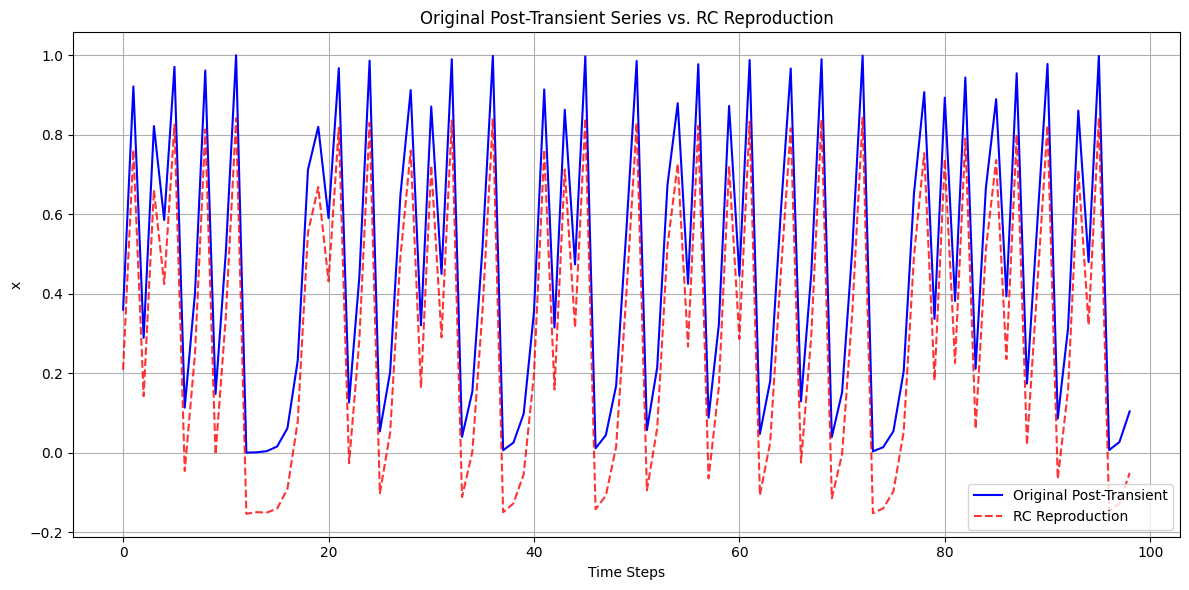

Mean Squared Error between Original and RC Reproduction: 0.023895


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge  # For output layer training

class EchoStateNetwork:
    def __init__(self, n_reservoir=200, spectral_radius=0.9, input_scaling=1.0, leak_rate=0.3, ridge_alpha=1e-6):
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.input_scaling = input_scaling
        self.leak_rate = leak_rate
        self.ridge_alpha = ridge_alpha
        self.W_in = None
        self.W_res = None
        self.W_out = None
        self.x = None  # Reservoir state

    def _initialize_weights(self, n_inputs=1):
        # Input weights: random, scaled
        self.W_in = np.random.uniform(-self.input_scaling, self.input_scaling, (self.n_reservoir, n_inputs))
        
        # Reservoir weights: random sparse, scaled to spectral radius
        self.W_res = np.random.uniform(-0.5, 0.5, (self.n_reservoir, self.n_reservoir))
        # Make sparse: keep 1% connections
        sparsity = 0.01
        n_connections = int(sparsity * self.n_reservoir**2)
        indices = np.random.choice(self.n_reservoir**2, n_connections, replace=False)
        self.W_res.flat[indices] = 0
        # Scale to spectral radius
        rho = np.max(np.abs(np.linalg.eigvals(self.W_res)))
        self.W_res /= rho / self.spectral_radius if rho != 0 else 1

    def _run_step(self, u):
        if self.x is None:
            self.x = np.zeros(self.n_reservoir)
        self.x = (1 - self.leak_rate) * self.x + self.leak_rate * np.tanh(np.dot(self.W_res, self.x) + np.dot(self.W_in, u))
        return self.x

    def fit(self, u, y):
        n_inputs = u.shape[1] if len(u.shape) > 1 else 1
        self._initialize_weights(n_inputs)
        
        # Collect reservoir states
        states = np.zeros((u.shape[0], self.n_reservoir))
        for t in range(u.shape[0]):
            states[t] = self._run_step(u[t])
        
        # Train output weights with Ridge regression (include bias)
        states_with_bias = np.hstack([np.ones((u.shape[0], 1)), states])
        self.W_out = Ridge(alpha=self.ridge_alpha).fit(states_with_bias, y).coef_  # 1D for single output

    def predict(self, u):
        predictions = []
        self.x = np.zeros(self.n_reservoir)  # Reset state
        for t in range(u.shape[0]):
            state = self._run_step(u[t])
            state_with_bias = np.hstack([1, state])
            pred = np.dot(self.W_out, state_with_bias)  # Scalar for single output
            predictions.append(pred)
        return np.array(predictions)

# Function to generate Logistic Map data
def logistic_map(x0, n_steps, r=4.0):
    """Logistic map: x_{n+1} = r * x_n * (1 - x_n)"""
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(1, n_steps):
        x[i] = r * x[i-1] * (1 - x[i-1])
    return x

# Generate data with transient
total_steps = 100
transient_steps = 0
x0 = 0.1
full_series = logistic_map(x0, total_steps)

# Post-transient data
post_transient_series = full_series[transient_steps:]

# Prepare training data: input u = x_t, target y = x_{t+1}
n_data = len(post_transient_series)
train_u = post_transient_series[:-1].reshape(-1, 1)
train_y = post_transient_series[1:].reshape(-1, 1)

# Train ESN on all post-transient data
esn = EchoStateNetwork(n_reservoir=1000, spectral_radius=1.2, leak_rate=0.1, input_scaling=1.0)
esn.fit(train_u, train_y)

# Generate reproduction: feed original u to get predictions (mimic y)
reproduced = esn.predict(train_u)

# Plot comparison: original post-transient vs RC reproduction
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
t = np.arange(n_data - 1)
ax.plot(t, post_transient_series[1:], label='Original Post-Transient', color='blue')
ax.plot(t, reproduced.flatten(), label='RC Reproduction', color='red', linestyle='--', alpha=0.8)
ax.set_title('Original Post-Transient Series vs. RC Reproduction')
ax.set_xlabel('Time Steps')
ax.set_ylabel('x')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# Compute and print MSE for quantitative comparison
mse = np.mean((post_transient_series[1:] - reproduced.flatten())**2)
print(f'Mean Squared Error between Original and RC Reproduction: {mse:.6f}')

# Use case:
# 1. Run the code to generate logistic map data, discard first 1000 transient steps.
# 2. Train RC on the post-transient data to mimic the map.
# 3. Feed the input sequence back to RC to reproduce the sequence (forced mode).
# 4. Plot compares the original target sequence with the RC output.
# 5. Adjust n_reservoir, spectral_radius, etc., for better fitting.
# 6. For other maps like Rulkov (2D), adapt to vector inputs/outputs.